In [1]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, DoubleType
import pyspark.sql.functions as sf
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
gc.enable()

import logging


logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
log_hendler = logging.FileHandler('DataQuality.log')
log_format = '%(asctime)s | %(levelname)s | %(message)s'
log_hendler.setFormatter(logging.Formatter(log_format))
logger.addHandler(log_hendler)

In [2]:
s3path = 'otus-mlops-bucket-bvo/fraud-data/'

In [3]:
# Запускаем команду s3cmd
s3path = 'otus-mlops-bucket-bvo/fraud-data/'
command = f's3cmd ls s3://{s3path}'
output = subprocess.check_output(command, shell=True)

# Обрабатываем вывод команды
files = output.decode().splitlines()

In [4]:
spark = SparkSession.builder.getOrCreate()

def read_txt(path: str) -> DataFrame:
    try:
        # Определение структуру схемы с типами StringType
        schema = StructType([
            StructField("transaction_id", StringType(), True),
            StructField("tx_datetime", StringType(), True),
            StructField("customer_id", StringType(), True),
            StructField("terminal_id", StringType(), True),
            StructField("tx_amount", StringType(), True),
            StructField("tx_time_seconds", StringType(), True),
            StructField("tx_time_days", StringType(), True),
            StructField("tx_fraud", StringType(), True),
            StructField("tx_fraud_scenario", StringType(), True)
        ])
        
        # Считывам .csv файл
        df = spark.read.format("csv") \
            .option("header", "true") \
            .option("delimiter", ",") \
            .schema(schema) \
            .load(f"s3a://{path}")
        
        return df
    except Exception as e:
         raise e

# Ошибка 1. Некорректная запись времени в "tx_datetime": 24:00:00

In [14]:
logger.info('Error 1. "tx_datetime" incorrect values.')
total_n_errors, total_n_corrects, total_n_nans = 0, 0, 0
for file in files:
    file_info = file.split()
    file_name = file_info[-1]
    df = read_txt(file_name.split('//')[-1])
    # Считаем количество наблюдений, которые не могут быть конвертированы в TimestampType
    n_errors = df.filter(df["tx_datetime"].cast(TimestampType()).isNull()).select('tx_datetime').count()
    total_n_errors += n_errors
    # Преоразовываем tx_time_seconds в дату и сверяем значения с tx_datetime. 
    # Сравниваем значения новой даты с tx_datetime и определяем количество расхождений.
    n_corrects = df\
    .withColumn("date", sf.expr("from_unixtime(unix_timestamp('2019-08-22 00:00:00') + tx_time_seconds)"))\
    .filter(sf.expr('tx_datetime != date')).select('tx_datetime').dropDuplicates().count()
    total_n_corrects += n_corrects
    # Считаем количество уникальных наблюдений, которые не могут быть конвертированы в TimestampType
    n_nans = df\
    .filter(df["tx_datetime"].cast(TimestampType()).isNull()).select('tx_datetime').dropDuplicates().count()
    total_n_nans += n_nans
    logger.info(f"File: {file_name.split('/')[-1]}; N Errors: {n_errors}; \
N Unique Corrected: {n_corrects}; N Unique NaNs: {n_nans}")
logger.info(f"Total N Errors: {total_n_errors}; \
Total N Unique Corrected: {total_n_corrects}; \
Total N Unique NaNs: {total_n_nans}\n")

#### В поле "tx_datetime" наблюдается ошибка с некорректной записью первой секунды нового дня. Например, значение '2019-08-22 24:00:00' должно на самом деле быть представлено как '2019-08-23 00:00:00'.  Попытка конвертации в TimestampType приводит к значению NaN. В результате анализа установлено, что корректное значение "tx_datetime" может быть восстановлена из значения  "tx_time_seconds". Некорректные записи следует исправить. Можно применить метод `.withColumn("tx_datetime", sf.expr("from_unixtime(unix_timestamp('2019-08-22 00:00:00') + tx_time_seconds)"))`. Однако в результате корректировок таким методом видим, что расходятся значения "N Unique Corrected" и "N Unique NaNs". Cкорректировали больше, чем требовалось. Смотрим.

In [115]:
# Выбираем файл с большим количеством корректировок N Unique Corrected
file = files[3]
file_info = file.split()
file_name = file_info[-1]
df = read_txt(file_name.split('//')[-1])
sample = df\
    .withColumn("date", sf.expr("from_unixtime(unix_timestamp('2019-08-22 00:00:00') + tx_time_seconds)"))\
    .filter(sf.expr('tx_datetime != date')).toPandas()

#### Наблюдаются расхождения tx_datetime и date. Секунда 72099 соответствует секундам первого дня '2019-08-22'. Однако tx_datetime соответствует транзакциям через 3 месяца. Или информация о транзакции пришла на 3 месяца позже, или значение "tx_time_seconds" неправльное. Следует уточнить с чем связаны проблемы, но попробуем предположить, что с учетом значений записи "tx_time_days" и порядка записи "transaction_id", а также файла с которым пришло данное расхождения, то вероятнее всего ошибка в записи "tx_time_seconds".

In [109]:
# Сортируем по "date" и смотрим на "tx_time_seconds"
sample.sort_values(by='date').head()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,date
126,150659825,2019-11-26 13:03:39,181465,911,47.38,72099,96,0,0,2019-08-22 20:01:39
391,175206175,2019-12-11 13:15:19,851216,882,24.60,194002,111,0,0,2019-08-24 05:53:22
491,184095892,2019-12-17 19:58:41,528202,479,125.35,194812,117,0,0,2019-08-24 06:06:52
92,148403656,2019-11-24 10:19:19,739800,457,48.68,200375,94,0,0,2019-08-24 07:39:35
235,160257255,2019-12-02 12:22:57,310418,211,44.39,200979,102,0,0,2019-08-24 07:49:39


In [110]:
# Сортируем по "transaction_id" и смотрим на "date"
sample.sort_values(by='transaction_id').head()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,date
0,140978307,2019-11-20 15:07:47,758,837,14.04,2980627,90,0,0,2019-09-25 11:57:07
1,141330537,2019-11-20 12:36:12,226628,818,12.02,378177,90,0,0,2019-08-26 09:02:57
2,141335450,2019-11-20 16:46:20,229776,86,97.58,2858798,90,0,0,2019-09-24 02:06:38
3,141346922,2019-11-20 16:56:21,237204,159,35.75,2868817,90,0,0,2019-09-24 04:53:37
4,141368212,2019-11-20 03:48:03,250889,581,34.43,2655996,90,0,0,2019-09-21 17:46:36


#### Таким образом нам не подходит описанный выше метод корректировки. Попробуем явно скорректировать значния полуночи

In [105]:
# Это те самые значения "tx_datetime", которые при конвертации становятся NaN
df.filter(sf.expr("substr(tx_datetime, 12) == '24:00:00'"))\
.limit(5).toPandas()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
0,141746420,2019-11-20 24:00:00,492357,841,5.01,7862400,90,0,0
1,142432376,2019-11-20 24:00:00,929425,873,96.48,7862400,90,0,0
2,143364038,2019-11-21 24:00:00,524619,281,35.30,7948800,91,0,0
3,143411213,2019-11-21 24:00:00,554360,843,67.01,7948800,91,0,0
4,144660802,2019-11-22 24:00:00,351572,536,182.13,8035200,92,0,0


In [119]:
# Явно сконвертируем строки, в которых стоит значение 24 часа
df = df.withColumn('date', sf.expr(
    "if(substr(tx_datetime, 12) == '24:00:00', \
    from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), \
    tx_datetime)"
).cast(StringType()))

In [120]:
# Проверяем сколько строк не смогло конвертироваться
df.filter(df["date"].cast(TimestampType()).isNull()).select('tx_datetime').dropDuplicates().count()

0

In [122]:
# Проверяем количество расхождений с первоначальным вектором. Должно соответствовать количеству первоначальных NaN
df.filter(sf.expr('tx_datetime != date')).count()

91

In [124]:
# Финальная проверка
logger.info('Error 1. "tx_datetime" incorrect values. Fixed')
total_n_errors, total_n_corrects, total_n_nans = 0, 0, 0
for file in files:
    file_info = file.split()
    file_name = file_info[-1]
    df = read_txt(file_name.split('//')[-1])
    # Считаем количество наблюдений, которые не могут быть конвертированы в TimestampType
    n_errors = df.filter(df["tx_datetime"].cast(TimestampType()).isNull()).select('tx_datetime').count()
    total_n_errors += n_errors
    # Преоразовываем tx_time_seconds в дату и сверяем значения с tx_datetime. 
    # Сравниваем значения новой даты с tx_datetime и определяем количество расхождений.
    n_corrects = df\
    .withColumn('date', sf.expr(
        "if(substr(tx_datetime, 12) == '24:00:00', \
        from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), \
        tx_datetime)"
    ).cast(StringType()))\
    .filter(sf.expr('tx_datetime != date')).select('tx_datetime').dropDuplicates().count()
    total_n_corrects += n_corrects
    # Считаем количество уникальных наблюдений, которые не могут быть конвертированы в TimestampType
    n_nans = df\
    .filter(df["tx_datetime"].cast(TimestampType()).isNull()).select('tx_datetime').dropDuplicates().count()
    total_n_nans += n_nans
    logger.info(f"File: {file_name.split('/')[-1]}; N Errors: {n_errors}; \
N Unique Corrected: {n_corrects}; N Unique NaNs: {n_nans}")
logger.info(f"Total N Errors: {total_n_errors}; \
Total N Unique Corrected: {total_n_corrects}; \
Total N Unique NaNs: {total_n_nans}\n")

#### Финальное выражение для корректировки времени 'tx_datetime': 
`
.withColumn('tx_datetime', sf.date_format(sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
).cast(TimestampType()), 'yyyy-MM-dd HH:mm:ss'))
`
#### Исправлено 3805 наблюдений (1160 уникальных значений).

# Ошибка 2. Ошибка в значениях "tx_time_seconds". Некорректная точка отсчета

#### При анализе Ошибки 1 выявлены расхождения в "tx_time_seconds". Некорректные записи следует исправить. Предполагаем, что ошибки "tx_datetime" устранены и корректное значение "tx_time_seconds" можно вывести из этого "tx_datetime".

In [136]:
file = files[3]
file_info = file.split()
file_name = file_info[-1]
df = read_txt(file_name.split('//')[-1])

In [138]:
# Пробуем получь 'tx_time_seconds' дату из 'tx_datetime'
df\
.withColumn('tx_datetime', sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
).cast(TimestampType()))\
.withColumn('new_tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) - \
unix_timestamp('2019-08-22 00:00:00')"))\
.limit(5).toPandas()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,new_tx_time_seconds
0,140977149,2019-11-20 20:49:17,0,350,76.20,7850957,90,0,0,7850957
1,140977150,2019-11-20 06:59:47,0,817,30.96,7801187,90,0,0,7801187
2,140977151,2019-11-20 17:50:46,1,269,65.82,7840246,90,0,0,7840246
3,140977152,2019-11-20 13:05:49,1,981,15.91,7823149,90,0,0,7823149
4,140977153,2019-11-20 16:20:57,3,732,1.19,7834857,90,0,0,7834857


In [140]:
# Сморим расхождения
df\
.withColumn('tx_datetime', sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
).cast(TimestampType()))\
.withColumn('new_tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) - \
unix_timestamp('2019-08-22 00:00:00')").cast(IntegerType()))\
.filter(sf.expr('new_tx_time_seconds != tx_time_seconds')).limit(5).toPandas()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,new_tx_time_seconds
0,140978307,2019-11-20 15:07:47,758,837,14.04,2980627,90,0,0,7830467
1,141330537,2019-11-20 12:36:12,226628,818,12.02,378177,90,0,0,7821372
2,141335450,2019-11-20 16:46:20,229776,86,97.58,2858798,90,0,0,7836380
3,141346922,2019-11-20 16:56:21,237204,159,35.75,2868817,90,0,0,7836981
4,141368212,2019-11-20 03:48:03,250889,581,34.43,2655996,90,0,0,7789683


In [143]:
logger.info('Error 2. "tx_time_seconds" incorrect values.')
total_n_corrects, total_n_nans = 0, 0
for file in files:
    file_info = file.split()
    file_name = file_info[-1]
    df = read_txt(file_name.split('//')[-1])
    df = df\
        .withColumn('tx_datetime', sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
        from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
        ).cast(TimestampType()))\
        .withColumn('new_tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) - \
        unix_timestamp('2019-08-22 00:00:00')").cast(IntegerType()))
    # Считаем количество наблюдений, которые ичправлены
    n_corrects = df.filter(sf.expr('new_tx_time_seconds != tx_time_seconds')).count()
    total_n_corrects += n_corrects
    # Считаем количество уникальных наблюдений, которые не могут быть конвертированы в TimestampType
    n_nans = df.filter(df['new_tx_time_seconds'].isNull()).count()
    total_n_nans += n_nans
    logger.info(f"File: {file_name.split('/')[-1]}; N Corrected: {n_corrects}; N NaNs: {n_nans}")
logger.info(f"Total N Unique Corrected: {total_n_corrects}; Total N Unique NaNs: {total_n_nans}\n")

#### Финальное выражение для корректировки времени 'tx_datetime': 
`
.withColumn('tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) -
unix_timestamp('2019-08-22 00:00:00')").cast(IntegerType()))
`
#### Исправлено 14444 наблюдений 

# Ошибка 3. Ошибка в значениях "tx_time_days", в случе некорретного значения "tx_datetime"

#### При анализе ошибки 1 выявлены случае некорректных значений "tx_time_days" в случае некорректных "tx_datetime" для полуночи. Например, для tx_datetime  = "2019-08-22 24:00:00" значение "tx_time_days" = 0, а на самом деле должно быть 1, т.к. корректная запись даты "2019-08-23 00:00:00", а "2019-08-22 00:00:00" - нулевая точка отсчета. Можно вывести из скорректированного "tx_time_seconds".

In [163]:
file = files[3]
file_info = file.split()
file_name = file_info[-1]
df = read_txt(file_name.split('//')[-1])

In [164]:
# Пробуем получь 'tx_time_days' дату из 'tx_time_seconds'
df\
.withColumn('tx_datetime', sf.date_format(sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
).cast(TimestampType()), 'yyyy-MM-dd HH:mm:ss'))\
.withColumn('tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) - \
unix_timestamp('2019-08-22 00:00:00')").cast(IntegerType()))\
.withColumn('new_tx_time_days', sf.expr("tx_time_seconds / 86400").cast(IntegerType()))\
.limit(5).toPandas()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,new_tx_time_days
0,140977149,2019-11-20 20:49:17,0,350,76.20,7850957,90,0,0,90
1,140977150,2019-11-20 06:59:47,0,817,30.96,7801187,90,0,0,90
2,140977151,2019-11-20 17:50:46,1,269,65.82,7840246,90,0,0,90
3,140977152,2019-11-20 13:05:49,1,981,15.91,7823149,90,0,0,90
4,140977153,2019-11-20 16:20:57,3,732,1.19,7834857,90,0,0,90


In [165]:
# Сморим расхождения
df\
.withColumn('tx_datetime', sf.date_format(sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
).cast(TimestampType()), 'yyyy-MM-dd HH:mm:ss'))\
.withColumn('tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) - \
unix_timestamp('2019-08-22 00:00:00')").cast(IntegerType()))\
.withColumn('new_tx_time_days', sf.expr("tx_time_seconds / 86400").cast(IntegerType()))\
.filter(sf.expr('new_tx_time_days != tx_time_days')).limit(5).toPandas()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,new_tx_time_days
0,141746420,2019-11-21 00:00:00,492357,841,5.01,7862400,90,0,0,91
1,142432376,2019-11-21 00:00:00,929425,873,96.48,7862400,90,0,0,91
2,143364038,2019-11-22 00:00:00,524619,281,35.30,7948800,91,0,0,92
3,143411213,2019-11-22 00:00:00,554360,843,67.01,7948800,91,0,0,92
4,144660802,2019-11-23 00:00:00,351572,536,182.13,8035200,92,0,0,93


In [169]:
logger.info('Error 3. "tx_time_days" incorrect values.')
total_n_corrects, total_n_nans = 0, 0
for file in files:
    file_info = file.split()
    file_name = file_info[-1]
    df = read_txt(file_name.split('//')[-1])
    df = df\
        .withColumn('tx_datetime', sf.date_format(sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
        from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
        ).cast(TimestampType()), 'yyyy-MM-dd HH:mm:ss'))\
        .withColumn('tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) - \
        unix_timestamp('2019-08-22 00:00:00')").cast(IntegerType()))\
        .withColumn('new_tx_time_days', sf.expr("tx_time_seconds / 86400").cast(IntegerType()))
    # Считаем количество наблюдений, которые ичправлены
    n_corrects = df.filter(sf.expr('new_tx_time_days != tx_time_days')).count()
    total_n_corrects += n_corrects
    # Считаем количество уникальных наблюдений, которые не могут быть конвертированы в TimestampType
    n_nans = df.filter(df['new_tx_time_days'].isNull()).count()
    total_n_nans += n_nans
    logger.info(f"File: {file_name.split('/')[-1]}; N Corrected: {n_corrects}; N NaNs: {n_nans}")
logger.info(f"Total N Unique Corrected: {total_n_corrects}; Total N Unique NaNs: {total_n_nans}\n")

#### Финальное выражение для корректировки времени 'tx_time_seconds': 
`
.withColumn('tx_time_days', sf.expr("tx_time_seconds / 86400").cast(IntegerType()))
`
#### Исправлено 3805 наблюдений. Совпадает с количеством исправлений "tx_datetime", что и ожидалось.

# Ошибка 4. Дублирование записей

#### При анализе 'transaction_id' выявлены дубли. Более подробный анализ показал, что дубли по 'transaction_id' соответсвуют дублям по строкам.

In [170]:
logger.info('Error 4. Duplicates.')
total_n_unique_by_file, total_n_duplicates_by_file = 0, 0
for file in files:
    file_info = file.split()
    file_name = file_info[-1]
    # Считаем количество строк
    n = read_txt(file_name.split('//')[-1]).select('transaction_id').count()
    # Считаем количество уникальных значений 'transaction_id'
    n_unique = read_txt(file_name.split('//')[-1]).select('transaction_id').distinct().count()
    # Cчитаем количество срок после удаление дублей
    n_drop_duplicates = read_txt(file_name.split('//')[-1]).dropDuplicates().select('transaction_id').count()
    total_n_unique_by_file += n_unique
    # Cчитаем количество дублей
    n_duplicates = n-n_unique
    total_n_duplicates_by_file += n_duplicates
    logger.info(f"File: {file_name.split('/')[-1]}; N: {n}; N Unique: {n_unique}; \
N After Drop Duplicates: {n_drop_duplicates}; N Duplicates: {n_duplicates}")
# Считаем количество строк во всех файлах после удаления дублей
total_n_unique_all = read_txt(s3path).select('transaction_id').distinct().count()
logger.info(f"Total N Unique: {total_n_unique_all}; \
Sum N Unique Per File: {total_n_unique_by_file}; \
Sum N Duplicates Per File: {total_n_duplicates_by_file}\n")

#### Обнаружено 2553 дубликатов. Применяем метод `.dropDuplicates()`

# Проблема 5. Некореектные значения в "terminal_id": NaN, "Err", некорректной длины

#### Некорректные значения по "terminal_id" допустимы для моделирования, если по ним наблюдаются мошеннические операции. Изучаем.

In [53]:
df = read_txt(s3path)

In [55]:
df.filter(df['terminal_id'].isNull())\
.groupBy('terminal_id')\
.agg({'transaction_id': 'count', 'tx_fraud':'mean'})\
.toPandas()

,terminal_id,count(transaction_id),avg(tx_fraud)
0,None,13060,0.059035


In [56]:
# "Err" и None имеют схожую долю фрод операций. Можно объединить в одну категорию
df.filter(df['terminal_id'] == 'Err')\
.groupBy('terminal_id')\
.agg({'transaction_id': 'count', 'tx_fraud':'mean'}).toPandas()

,terminal_id,count(transaction_id),avg(tx_fraud)
0,Err,27252,0.058821


In [54]:
# В этих аномальных "terminal_id" наблюдается низкие значния. 
# Похоже на номера телефонов, почтовые индексы или id товаров
# Имеет смысл объединить все "terminal_id" с длиной > 3 в одну категорию.
df.filter(sf.length(df['terminal_id']) > 3)\
.groupBy('terminal_id').agg({'transaction_id': 'count', 'tx_fraud':'mean'}).toPandas()\
.sort_values(by=['count(transaction_id)'], ascending=False)

,terminal_id,count(transaction_id),avg(tx_fraud)
1,89518096,513023,0.000928
2,21861,59066,0.000745
4,618230,2643,0.000757
5,22225,333,0.000000
3,436002,90,0.000000
0,22129,1,0.000000
6,360740,1,0.000000


In [141]:
file = files[1]
file_info = file.split()
file_name = file_info[-1]
df = read_txt(file_name.split('//')[-1])

In [152]:
sample = df\
.withColumn('terminal_id', sf.when(sf.length(sf.col('terminal_id')) > 3, 1000).otherwise(sf.col('terminal_id')))\
.withColumn('terminal_id', sf.when(sf.col('terminal_id').isNull() | (sf.col('terminal_id') == 'Err'), -1)\
            .otherwise(sf.col('terminal_id')).cast(IntegerType()))\
.withColumn('scenario_1', sf.when(sf.col('tx_fraud_scenario') == '1', 1).otherwise(0).cast(IntegerType()))\
.withColumn('scenario_2', sf.when(sf.col('tx_fraud_scenario') == '2', 1).otherwise(0).cast(IntegerType()))\
.withColumn('scenario_3', sf.when(sf.col('tx_fraud_scenario') == '3', 1).otherwise(0).cast(IntegerType()))\
.groupBy(['terminal_id', 'tx_time_days']).agg({
    'transaction_id': 'count', 'tx_fraud': 'mean', 'scenario_1': 'mean', 'scenario_2': 'mean', 'scenario_3': 'mean'}).toPandas()

sample['tx_time_days'] = sample['tx_time_days'].astype('int')
sample = sample.sort_values(by=['terminal_id', 'tx_time_days'], ascending=True).reset_index(drop=True)

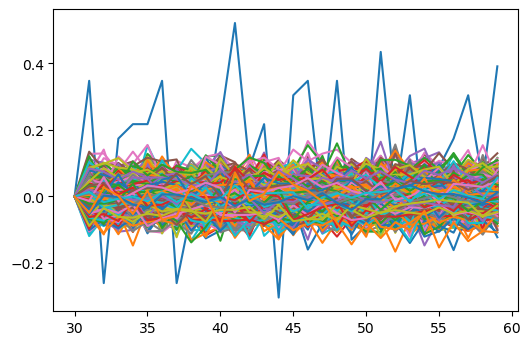

In [153]:
# Наибольшая дисперсия у новой категории, с длиной 'terminal_id' > 3
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['count(transaction_id)']
    plt.plot(vector / vector.iloc[0] - 1)
plt.show()

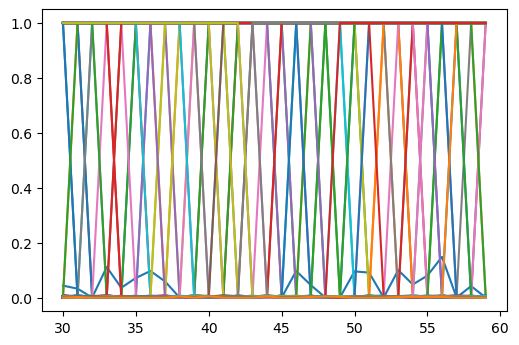

In [154]:
# Это что за дескритизация фрода во времени? Cинтетика?
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['avg(tx_fraud)']
    plt.plot(vector)
plt.show()

Empty list: [60, 130, 298, 699, 869]


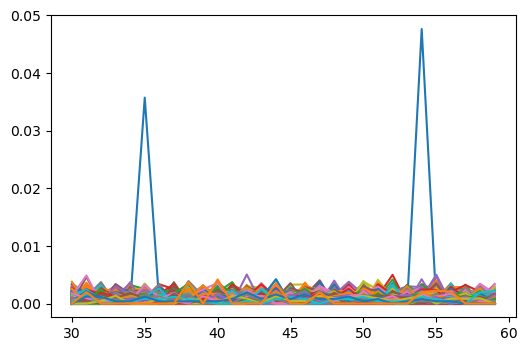

In [188]:
# Выглядит нормально. Но откланяется с None и Err что-то не так. Также часть с отстуствием фрода
empty = []
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['avg(scenario_1)']
    if vector.sum() == 0:
        empty.append(terminal_id)
    plt.plot(vector)
    
print(f"Empty list: {empty}")

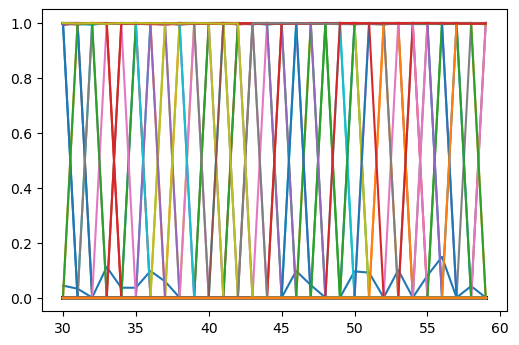

In [189]:
# Дискретизация! Не дескритизирована категория с NaN и "Err"
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['avg(scenario_2)']
    plt.plot(vector)
plt.show()

#### Предположение. Есть синтетические данные, которые нужно исключить, при этом могут быть не только данные по отдельным транзакциям, но по всем транзакциям клиентов или терминалам, в которых проходит данная транзация.

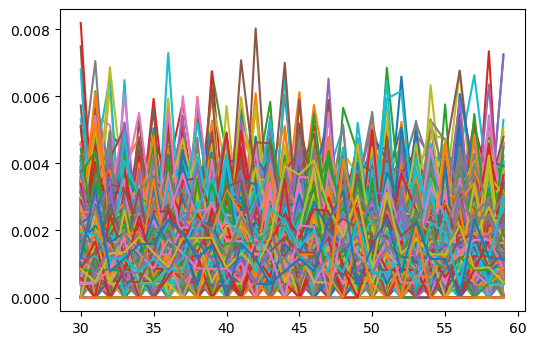

Empty list: [-1]


In [190]:
# Выгляди нормально. Но у категории с None и Err отсуствует фрод
empty = []
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['avg(scenario_3)']
    if vector.sum() == 0:
        empty.append(terminal_id)
    plt.plot(vector)
plt.show()

print(f"Empty list: {empty}")

## Собираем все вместе, с учетом корректировки временного ряда на предыдущих шагах и пытаемся найти сезонность

In [73]:
%%time
df = read_txt(s3path)
sample = df.dropDuplicates()\
.withColumn('tx_datetime', sf.date_format(sf.expr( "if(substr(tx_datetime, 12) == '24:00:00', \
from_unixtime(unix_timestamp(substr(tx_datetime, 0, 11) || '00:00:00') + 86400), tx_datetime)" 
).cast(TimestampType()), 'yyyy-MM-dd HH:mm:ss'))\
.withColumn('tx_time_seconds', sf.expr("unix_timestamp(tx_datetime) - \
unix_timestamp('2019-08-22 00:00:00')").cast(IntegerType()))\
.withColumn('tx_time_days', sf.expr("tx_time_seconds / 86400").cast(IntegerType()))\
.withColumn('terminal_id', sf.when(sf.length(sf.col('terminal_id')) > 3, 1000).otherwise(sf.col('terminal_id')))\
.withColumn('scenario_1', sf.when(sf.col('tx_fraud_scenario') == '1', 1).otherwise(0).cast(IntegerType()))\
.withColumn('scenario_2', sf.when(sf.col('tx_fraud_scenario') == '2', 1).otherwise(0).cast(IntegerType()))\
.withColumn('scenario_3', sf.when(sf.col('tx_fraud_scenario') == '3', 1).otherwise(0).cast(IntegerType()))\
.filter(~(sf.col('customer_id') == -999999))\
.filter(~(sf.col('terminal_id').isNull() | (sf.col('terminal_id') == 'Err')))\
.groupBy(['terminal_id', 'tx_time_days']).agg({
    'transaction_id': 'count', 'tx_fraud': 'mean', 'scenario_1': 'mean', 'scenario_2': 'mean', 'scenario_3': 'mean'}).toPandas()

sample['tx_time_days'] = sample['tx_time_days'].astype('int')
sample['terminal_id'] = sample['terminal_id'].astype('int')
sample = sample.sort_values(by=['terminal_id', 'tx_time_days'], ascending=True).reset_index(drop=True)

CPU times: user 6.85 s, sys: 565 ms, total: 7.42 s
Wall time: 58min


In [74]:
sample.to_csv('sample.csv', index=False)

Empty list: []


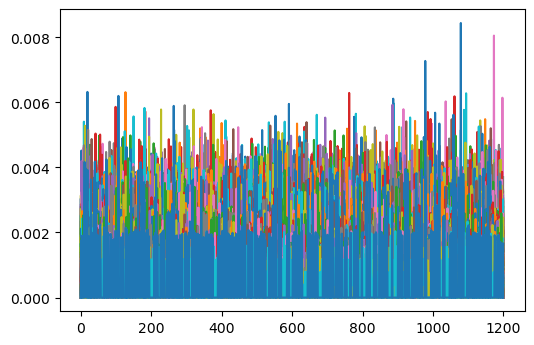

In [75]:
# Выглядит нормально. Но откланяется с None и Err что-то не так. Также часть с отстуствием фрода
empty = []
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['avg(scenario_1)']
    if vector.sum() == 0:
        empty.append(terminal_id)
    plt.plot(vector)
    
print(f"Empty list: {empty}")

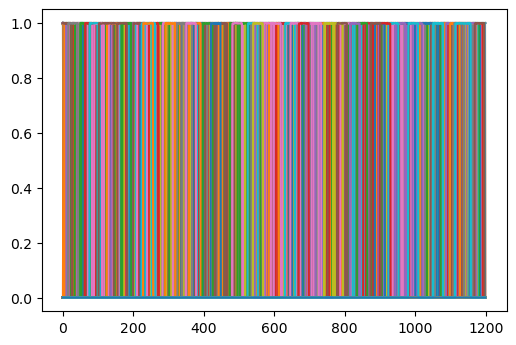

Empty list: [3, 46, 48, 50, 70, 72, 101, 103, 141, 144, 148, 149, 163, 180, 186, 194, 212, 217, 222, 228, 232, 257, 261, 269, 276, 285, 296, 300, 318, 339, 362, 364, 372, 391, 396, 405, 438, 477, 478, 494, 506, 524, 531, 540, 548, 554, 560, 593, 602, 631, 637, 642, 644, 662, 666, 669, 674, 675, 677, 683, 689, 693, 703, 707, 708, 723, 730, 732, 735, 744, 748, 760, 765, 780, 786, 789, 794, 801, 810, 811, 818, 824, 835, 858, 862, 875, 879, 881, 886, 887, 888, 893, 905, 912, 914, 924, 947, 958, 968, 977, 1000]


In [76]:
# Дискретизация!
empty = []
not_empty = []
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['avg(scenario_2)']
    if vector.sum() == 0:
        empty.append(terminal_id)
    else:
        not_empty.append(terminal_id)
    plt.plot(vector)
plt.show()

print(f"Empty list: {empty}")

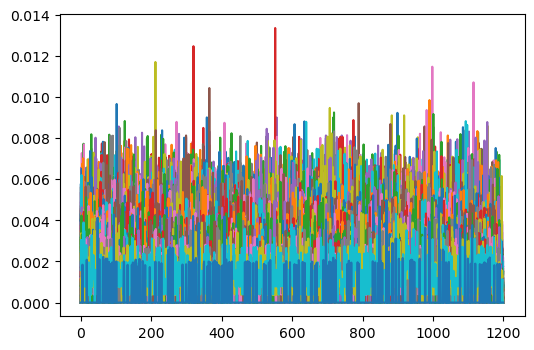

Empty list: []


In [77]:
# Выгляди нормально. Но у категории с None и Err отсуствует фрод
empty = []
plt.figure(dpi=100)
for terminal_id in sample['terminal_id'].unique():
    vector = sample[sample['terminal_id'] == terminal_id].set_index('tx_time_days')['avg(scenario_3)']
    if vector.sum() == 0:
        empty.append(terminal_id)
    plt.plot(vector)
plt.show()

print(f"Empty list: {empty}")

#### Решено удалить наблюдения с None и "Err", а также с нарушением формата записи. По None и "Err" наблюдается некорректное поведение по  2-му сценарию фрода.

# Проблема 6. Некорректное значение в "customer_id": -999999

In [17]:
df = read_txt(s3path)

In [18]:
df.filter(df['customer_id'] == -999999)\
.groupBy('customer_id')\
.agg({'transaction_id': 'count', 'tx_fraud':'mean'}).toPandas()

,customer_id,count(transaction_id),avg(tx_fraud)
0,-999999,14623,0.060111


In [19]:
df.filter((df['customer_id'] == -999999) & (df['tx_fraud'] == 1)).limit(5).toPandas()

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
0,14130820,2019-08-31 13:45:26,-999999,338,83.60,827126,9,1,2
1,48114562,2019-09-21 15:41:05,-999999,331,99.89,2648465,30,1,2
2,55222438,2019-09-26 14:41:48,-999999,601,9.81,3076908,35,1,2
3,57574568,2019-09-27 12:30:45,-999999,853,61.03,3155445,36,1,2
4,57778048,2019-09-27 08:33:08,-999999,987,96.83,3141188,36,1,2


In [20]:
df.filter((df['customer_id'] == -999999) & (df['tx_fraud'] == 1))\
.groupBy('tx_fraud_scenario')\
.agg({'transaction_id': 'count'}).toPandas()

,tx_fraud_scenario,count(transaction_id)
0,3,14
1,1,9
2,2,856


#### Большинство фродовых транзакций, совершенные по 'customer_id' == -999999 относятся к дискретизированному фроду категории 2.

# Проблема 7. Выбросы по количеству наблюдений в некоторых "terminal_id": { 0, 145, 81, 97 }

In [5]:
transaction_count_all = []
for file in files:
    file_info = file.split()
    file_name = file_info[-1]
    transaction_count_all.append(transaction_count(file_name))
transaction_count_all = pd.concat(transaction_count_all, axis=0)

In [6]:
# Validity Type Error: Mandatory Constraints
n_nan = transaction_count_all[transaction_count_all['terminal_id'].isnull()]['transaction_count'].sum()
print(f"Количество транзаций, в которых значение для 'terminal_id' NaN: {n_nan}")
transaction_count_all['terminal_id'] = transaction_count_all['terminal_id'].replace(pd.NaT, '-1')

# Validity Type Error: Data-Type Constraints
n_err = transaction_count_all[transaction_count_all['terminal_id'] == 'Err']['transaction_count'].sum()
print(f"Количество транзаций, в которых значение для 'terminal_id' 'Err': {n_err}")
transaction_count_all['terminal_id'] = transaction_count_all['terminal_id'].replace('Err', '-2')

# Validity Type Error: Range Constraints
n_len = transaction_count_all[transaction_count_all['terminal_id'].apply(lambda s: len(s) > 4)]['transaction_count'].sum()
print(f"Количество транзаций, в которых некоректно указано значение для 'terminal_id' (длина > 4): {n_len}")
transaction_count_all['terminal_id'] = transaction_count_all['terminal_id'].apply(lambda s: '-3' if len(s) > 4 else s)

transaction_count_all['terminal_id'] = transaction_count_all['terminal_id'].astype(int)

Количество транзаций, в которых значение для 'terminal_id' NaN: 13060
Количество транзаций, в которых значение для 'terminal_id' 'Err': 27252
Количество транзаций, в которых некоректно указано значение для 'terminal_id' (длина > 4): 575157


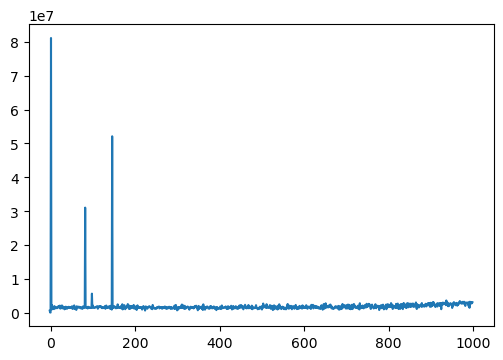

In [7]:
plt.figure(dpi=100)
plt.plot(transaction_count_all.groupby(by=['terminal_id']).aggregate({'transaction_count': 'sum'}))
plt.show()

In [8]:
# Outliers Type Error

transaction_count_all\
.groupby(by=['terminal_id'])\
.aggregate({'transaction_count': 'sum'})\
.sort_values(by=['transaction_count'], ascending=False)\
.head(10)

,transaction_count
terminal_id,
0,81177681
145,52123884
81,31032860
97,5603037
937,3582605
969,3424148
993,3208580
979,3208534
975,3182108


In [9]:
del transaction_count_all
gc.collect()

2547

### Наблюдаются выбросы в "terminal_id": { 0, 145, 81, 97 }. На данном этапе ничего не делаем, но имеем ввиду. Возможно причина в других данных.